# Machine Learning 2021 Final Project
## Human Activity Recognition
### Oliver Wandschneider

#### Dataset
The dataset used consists of accelerometer and gyroscope data that was collected using a waist mounted smartphone. It can be downloaded [here](https://archive.ics.uci.edu/ml/machine-learning-databases/00341/HAPT%20Data%20Set.zip) but it is also possible to let it download automatically. This happens when the ``dataset/`` directory doesn't exist upon execution.

In [65]:
import io
import os
import zipfile

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import seaborn as sn
import tensorflow as tf
import tensorflow_addons as tfa
from sklearn.metrics import classification_report
from tensorflow.keras import layers

np.set_printoptions(precision=3, suppress=True)

#
# Download the dataset directly.
#
if not os.path.isdir("dataset"):
    req = requests.get("https://archive.ics.uci.edu/ml/machine-learning-databases/00341/HAPT%20Data%20Set.zip")
    if req.ok:
        zipped = zipfile.ZipFile(io.BytesIO(req.content))
        zipped.extractall("dataset")
    else:
        print("Could not download the data. Add it manually.")


#### Loading the data
First of all the dataset is loaded. Both the train and the test data and their corresponding labels loaded as a 2-D array.

In [66]:
#
# Load the csv data.
#
def load_data_arrays(feature_remove=None):
    data_path = "dataset"
    train_x_df = pd.read_csv(os.path.join(data_path, "Train/X_train.txt"), delimiter=" ", header=None)
    train_y_df = pd.read_csv(os.path.join(data_path, "Train/y_train.txt"), delimiter=" ", header=None)

    test_x_df = pd.read_csv(os.path.join(data_path, "Test/X_test.txt"), delimiter=" ", header=None)
    test_y_df = pd.read_csv(os.path.join(data_path, "Test/y_test.txt"), delimiter=" ", header=None)

    if feature_remove:
        for inx in feature_remove:
            del train_x_df[inx]
            del test_x_df[inx]

    features = train_x_df.copy().to_numpy()
    labels = train_y_df.copy().to_numpy()

    test_features = test_x_df.copy().to_numpy()
    test_labels = test_y_df.copy().to_numpy()

    return features, labels, test_features, test_labels


feat, label, t_feat, t_label = load_data_arrays()


[1722, 1544, 1407, 1801, 1979, 1958, 70, 33, 107, 85, 139, 84]


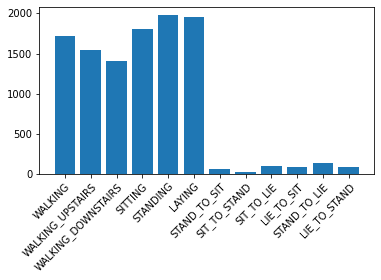

<Figure size 1152x720 with 0 Axes>

In [67]:
#
# Plots the distribution according to the number of occurences per label.
#
def plot_data_distribution(labels_1, label_2):
    total = labels_1.reshape(-1).tolist()
    total.extend(label_2.reshape(-1).tolist())
    bins = sorted(list(set(total)))

    plt.bar(bins, [total.count(bin_val) for bin_val in bins])
    print([total.count(bin_val) for bin_val in bins])
    plt.xticks(bins,
               ["WALKING", "WALKING_UPSTAIRS", "WALKING_DOWNSTAIRS", "SITTING", "STANDING", "LAYING",
                "STAND_TO_SIT", "SIT_TO_STAND", "SIT_TO_LIE", "LIE_TO_SIT", "STAND_TO_LIE", "LIE_TO_STAND"],
               rotation=45,
               rotation_mode="anchor",
               ha="right")

    plt.subplots_adjust(bottom=0.3)
    plt.figure(figsize=(16, 10))
    plt.show()


plot_data_distribution(label, t_label)


#### Splitting the dataset
Because the label distribution is very unbalanced, I will handle the activities (labels 1-6) and the transitions (labels 7-12) individually.

The following method is used to split the data into the activity and transition part.

In [68]:
#
# Function to split the data into two parts
# (activities = labels 1 to 6, transitions = labels 7 to 12)
#
def split_data_by_labels(feat_arr: np.array, label_arr: np.array, first_indices: list):
    part_one_feat = list()
    part_one_label = list()
    part_two_feat = list()
    part_two_label = list()

    for inx, lbl in enumerate(label_arr):
        if lbl[0] in first_indices:
            part_one_label.append(lbl[0])
            part_one_feat.append(feat_arr[inx])
        else:
            part_two_label.append(lbl[0])
            part_two_feat.append(feat_arr[inx])

    return np.asarray(part_one_feat), np.asarray(part_one_label), np.asarray(part_two_feat), np.asarray(part_two_label)


#
# Split the test data into activities and transitions.
#
train_feat, train_lab, trans_feat, trans_lab = split_data_by_labels(feat, label, [1, 2, 3, 4, 5, 6])
test_feat, test_lab, test_trans_feat, test_trans_lab = split_data_by_labels(t_feat, t_label, [1, 2, 3, 4, 5, 6])


In [69]:
#
# Creates a one hot encoded vector of a label.
#
def create_one_hot(array, num_classes=6, offset=0):
    return np.eye(num_classes)[array - 1 - offset]


#
# Plots a confusion matrix of the given labels.
#
def plot_confusion_matrix(labels, pred, index, columns):
    conf = tf.math.confusion_matrix(labels=[np.argmax(val) for val in labels],
                                    predictions=[np.argmax(val) for val in pred])

    df_cm = pd.DataFrame(conf.numpy(), index=index, columns=columns)

    plt.figure(figsize=(10, 7))
    plt.tick_params(axis='both', which='major', labelsize=14, labelbottom=False, bottom=False, top=False,
                    labeltop=True)
    sn.heatmap(df_cm, annot=True, cmap='Blues', fmt='g')
    plt.show()


#### Activity Model
The activity model contains an input layer of size 561, a dense layer of size 228, another dense layer of size 232 and a softmax activated output layer of size 6 (for 6 possible labels). In between the dense layers are also batch normalization layers.

Because this is a multilayer classification I use the Categorical Crossentropy as a loss function. The learning rate is 0.0001 and the model will train 25 epochs in total.

In [70]:
#
# Activities
#
enc_train_lab = create_one_hot(train_lab)
enc_test_lab = create_one_hot(test_lab)

activity_model = tf.keras.Sequential([
    layers.Dense(228, input_dim=train_feat.shape[1]),
    layers.BatchNormalization(),
    layers.Activation("sigmoid"),
    layers.Dense(232),
    layers.BatchNormalization(),
    layers.Activation("sigmoid"),
    layers.Dense(6, activation='softmax')
])

print(activity_model.summary())

activity_model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                       metrics=[tfa.metrics.f_scores.F1Score(6, "micro")],
                       optimizer=tf.optimizers.Adam(learning_rate=0.0001))

act_hist = activity_model.fit(train_feat, enc_train_lab,
                              epochs=25,
                              validation_data=(test_feat, enc_test_lab),
                              batch_size=64)

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_63 (Dense)             (None, 228)               128136    
_________________________________________________________________
batch_normalization_49 (Batc (None, 228)               912       
_________________________________________________________________
activation_42 (Activation)   (None, 228)               0         
_________________________________________________________________
dense_64 (Dense)             (None, 232)               53128     
_________________________________________________________________
batch_normalization_50 (Batc (None, 232)               928       
_________________________________________________________________
activation_43 (Activation)   (None, 232)               0         
_________________________________________________________________
dense_65 (Dense)             (None, 6)               

#### Transition Model
The transition model contains an input layer of size 561 that is a batch normalization layer. Then a dense layer of size 108, a batch normalization layer, and a dropout layer with a dropout rate of 0.5 follows.
A drouput layer randomly sets an input to 0 with the frequency being the dropout rate.

This is repeated with the dense layer having only 72 nerons this time and the output is also 6 neuron dense layer with a softmax activation.

In [71]:
#
# Transitions
#
enc_trans_lab = create_one_hot(trans_lab, num_classes=6, offset=6)
enc_test_trans_lab = create_one_hot(test_trans_lab, num_classes=6, offset=6)

transition_model = tf.keras.Sequential([
    layers.BatchNormalization(input_dim=trans_feat.shape[1]),
    layers.Dense(108),
    layers.BatchNormalization(),
    layers.Activation("sigmoid"),
    layers.Dropout(.5),
    layers.Dense(72),
    layers.BatchNormalization(),
    layers.Activation("sigmoid"),
    layers.Dropout(.5),
    layers.Dense(6, activation='softmax')
])

print(transition_model.summary())

transition_model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                         metrics=[tfa.metrics.f_scores.F1Score(6, "micro")],
                         optimizer=tf.optimizers.Adam(learning_rate=0.005))

trans_hist = transition_model.fit(trans_feat, enc_trans_lab,
                                  epochs=25,
                                  validation_data=(test_trans_feat, enc_test_trans_lab))


Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_51 (Batc (None, 561)               2244      
_________________________________________________________________
dense_66 (Dense)             (None, 108)               60696     
_________________________________________________________________
batch_normalization_52 (Batc (None, 108)               432       
_________________________________________________________________
activation_44 (Activation)   (None, 108)               0         
_________________________________________________________________
dropout_30 (Dropout)         (None, 108)               0         
_________________________________________________________________
dense_67 (Dense)             (None, 72)                7848      
_________________________________________________________________
batch_normalization_53 (Batc (None, 72)              

#### Model Evaluation
To decide if the learning rate is adequate I look at the plot of the loss over the epochs and evaluate them like this:
![](https://cs231n.github.io/assets/nn3/learningrates.jpeg)

Also for checking if the model over- or underfits I looked at the gap between training accuracy and validation accuracy as follows:
![](https://cs231n.github.io/assets/nn3/accuracies.jpeg)

Images: [(source)](https://cs231n.github.io/neural-networks-3/#baby)

Using a confusion matrix I plot the predicted and true labels that were assigned on the test data.

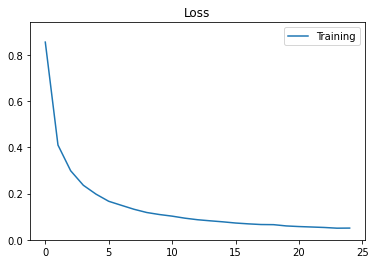

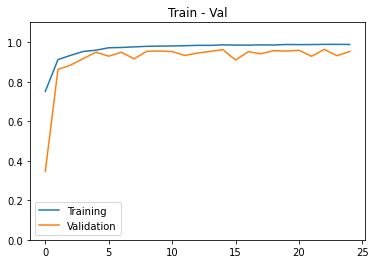

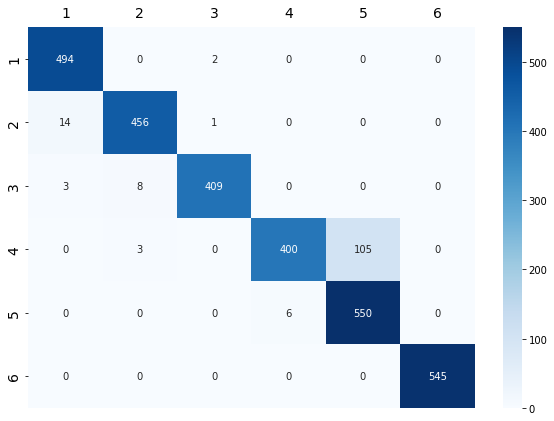

              precision    recall  f1-score   support

           0       0.97      1.00      0.98       496
           1       0.98      0.97      0.97       471
           2       0.99      0.97      0.98       420
           3       0.99      0.79      0.88       508
           4       0.84      0.99      0.91       556
           5       1.00      1.00      1.00       545

    accuracy                           0.95      2996
   macro avg       0.96      0.95      0.95      2996
weighted avg       0.96      0.95      0.95      2996



In [72]:
plt.ylim((0, max(act_hist.history["loss"]) * 1.1))
plt.plot(act_hist.history["loss"], label="Training")
plt.title("Loss")
plt.legend()
plt.show()

plt.ylim((0, 1.1))
plt.plot(act_hist.history["f1_score"], label="Training")
plt.plot(act_hist.history["val_f1_score"], label="Validation")
plt.title("Train - Val")
plt.legend()
plt.show()

act_pred = activity_model.predict(test_feat)
act_classes = [i for i in range(1, 7)]

plot_confusion_matrix(labels=enc_test_lab,
                      pred=act_pred,
                      index=act_classes,
                      columns=act_classes)

print(classification_report(enc_test_lab.argmax(axis=1), act_pred.argmax(axis=1)))

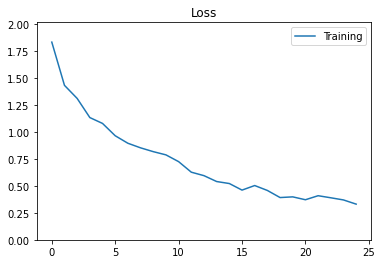

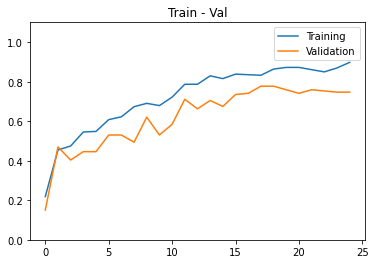

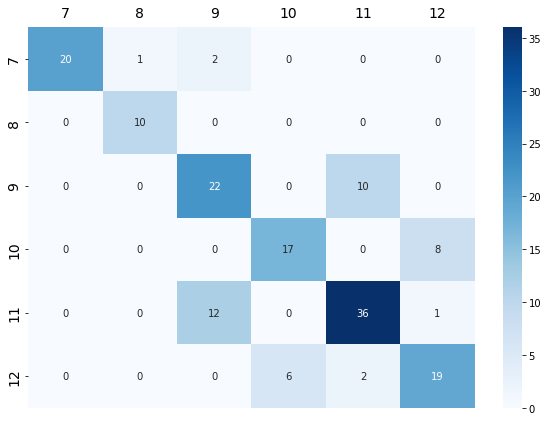

              precision    recall  f1-score   support

           7       1.00      0.87      0.93        23
           8       0.91      1.00      0.95        10
           9       0.61      0.69      0.65        32
          10       0.74      0.68      0.71        25
          11       0.75      0.73      0.74        49
          12       0.68      0.70      0.69        27

    accuracy                           0.75       166
   macro avg       0.78      0.78      0.78       166
weighted avg       0.75      0.75      0.75       166



In [73]:
plt.ylim((0, max(trans_hist.history["loss"]) * 1.1))
plt.plot(trans_hist.history["loss"], label="Training")
plt.title("Loss")
plt.legend()
plt.show()

plt.ylim((0, 1.1))
plt.plot(trans_hist.history["f1_score"], label="Training")
plt.plot(trans_hist.history["val_f1_score"], label="Validation")
plt.title("Train - Val")
plt.legend()
plt.show()

trans_pred = transition_model.predict(test_trans_feat)
trans_classes = [i for i in range(7, 13)]

plot_confusion_matrix(labels=enc_test_trans_lab,
                      pred=trans_pred,
                      index=trans_classes,
                      columns=trans_classes)

print(classification_report(enc_test_trans_lab.argmax(axis=1) + 7, trans_pred.argmax(axis=1) + 7))
